# This script should be ran using in a docker with Hailo Software Suite 
Follow this steps in x86 to create the docker container:

https://docs.google.com/document/d/17-5O9hAd642VEsHDL9d6Zh4XcVtaRl2u3CbN4AQ1mX4/edit?tab=t.0

In [3]:
# General imports used throughout the tutorial
import tensorflow as tf
from IPython.display import SVG

# import the ClientRunner class from the hailo_sdk_client package
from hailo_sdk_client import ClientRunner

In [4]:
chosen_hw_arch = "hailo8l"
# For Hailo-15 devices, use 'hailo15h'
# For Mini PCIe modules or Hailo-8R devices, use 'hailo8r'

In [5]:
onnx_model_name = "yolov5m_vehicles"
onnx_path = "./models/yolov5m_vehicles/yolov5m_vehicles.onnx"

In [6]:
runner = ClientRunner(hw_arch=chosen_hw_arch)
hn, npz = runner.translate_onnx_model(
    onnx_path,
)

[info] Translation started on ONNX model model
[info] Restored ONNX model model (completion time: 00:00:00.30)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:01.74)
[info] NMS structure of yolov5 (or equivalent architecture) was detected. Default values of NMS anchors were loaded to NMS config json
[info] Start nodes mapped from original model: 'images': 'model/input_layer1'.
[info] End nodes mapped from original model: 'Transpose_272', 'Transpose_288', 'Transpose_304'.
[info] Translation completed on ONNX model model (completion time: 00:00:03.17)


In [7]:
hailo_model_har_name = f"{onnx_model_name}_hailo_model.har"
runner.save_har(hailo_model_har_name)

[info] Saved HAR to: /local/workspace/hailo_virtualenv/lib/python3.10/site-packages/hailo_tutorials/notebooks/yolov5m_vehicles_hailo_model.har


[info] Current Time: 15:25:30, 06/26/25
[info] CPU: Architecture: x86_64, Model: 12th Gen Intel(R) Core(TM) i7-12700H, Number Of Cores: 20, Utilization: 2.0%
[info] Memory: Total: 15GB, Available: 5GB
[info] System info: OS: Linux, Kernel: 6.8.0-60-generic
[info] Hailo DFC Version: 3.30.0
[info] HailoRT Version: 4.20.0
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo visualizer yolov5m_vehicles_hailo_model.har --no-browser`


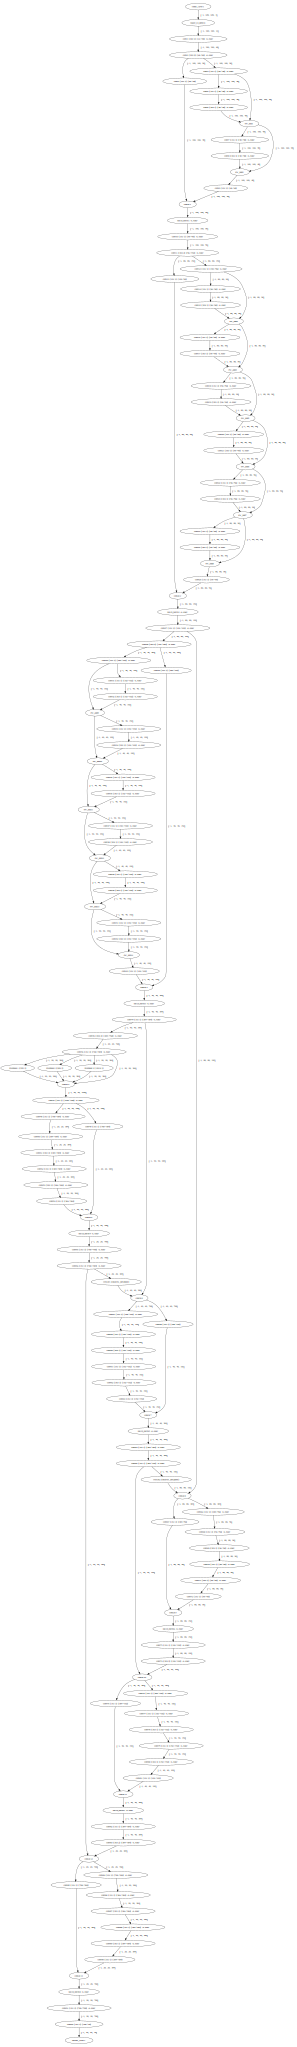

In [8]:
!hailo visualizer {hailo_model_har_name} --no-browser
SVG("yolov5m_vehicles.svg")

In [9]:
# General imports used throughout the tutorial
# file operations
import json
import os

import numpy as np
import tensorflow as tf
from IPython.display import SVG
from matplotlib import patches
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.python.eager.context import eager_mode

# import the hailo sdk client relevant classes
from hailo_sdk_client import ClientRunner, InferenceContext

%matplotlib inline

IMAGES_TO_VISUALIZE = 5

In [10]:
# First, we will prepare the calibration set. Resize the images to the correct size and crop them.
def preproc(image, output_height=640, output_width=640, resize_side=640):
    """imagenet-standard: aspect-preserving resize to 256px smaller-side, then central-crop to 224px"""
    with eager_mode():
        h, w = image.shape[0], image.shape[1]
        scale = tf.cond(tf.less(h, w), lambda: resize_side / h, lambda: resize_side / w)
        resized_image = tf.compat.v1.image.resize_bilinear(tf.expand_dims(image, 0), [int(h * scale), int(w * scale)])
        cropped_image = tf.compat.v1.image.resize_with_crop_or_pad(resized_image, output_height, output_width)

        return tf.squeeze(cropped_image)


images_path = "./models/yolov5m_vehicles/vehicle_dataset/"
images_list = [img_name for img_name in os.listdir(images_path) if os.path.splitext(img_name)[1] == ".jpg"]

calib_dataset = np.zeros((len(images_list), 640, 640, 3))
for idx, img_name in enumerate(sorted(images_list)):
    img = np.array(Image.open(os.path.join(images_path, img_name)).convert('RGB'))
    img_preproc = preproc(img)
    calib_dataset[idx, :, :, :] = img_preproc.numpy()

np.save("calib_set.npy", calib_dataset)

In [11]:
# Second, we will load our parsed HAR from the Parsing Tutorial

model_name = "yolov5m_vehicles"
hailo_model_har_name = f"{model_name}_hailo_model.har"
assert os.path.isfile(hailo_model_har_name), "Please provide valid path for HAR file"
runner = ClientRunner(har=hailo_model_har_name)
# By default it uses the hw_arch that is saved on the HAR. For overriding, use the hw_arch flag.

In [12]:
# Now we will create a model script, that tells the compiler to add a normalization on the beginning
# of the model (that is why we didn't normalize the calibration set;
# Otherwise we would have to normalize it before using it)

# Batch size is 8 by default
# alls = "normalization1 = normalization([123.675, 116.28, 103.53], [58.395, 57.12, 57.375])\n"

# Load the model script to ClientRunner so it will be considered on optimization
# runner.load_model_script(alls)



model_script_commands = [
    "normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n",
    "resize_input1= resize(resize_shapes=[640,640])\n",
    "nms_postprocess(meta_arch=yolov5, engine=cpu, nms_scores_th=0.2, nms_iou_th=0.4)\n",
]
# Note: Scores threshold of 0.0 means no filtering, 1.0 means maximal filtering. IoU thresholds are opposite: 1.0 means filtering boxes only if they are equal, and 0.0 means filtering with minimal overlap.
runner.load_model_script("".join(model_script_commands))




# Call Optimize to perform the optimization process
runner.optimize(calib_dataset)


# Infer an image with the Hailo Emulator
with runner.infer_context(InferenceContext.SDK_FP_OPTIMIZED) as ctx:
    nms_output = runner.infer(ctx, calib_dataset[:16, ...])
HEIGHT = 640
WIDTH = 640
# For each image
for i in range(16):
    found_any = False
    min_score = None
    max_score = None
    # Go over all classes
    for class_index in range(nms_output.shape[1]):
        score, box = nms_output[i][class_index, 4, :], nms_output[i][class_index, 0:4, :]
        # Go over all detections
        for detection_idx in range(box.shape[1]):
            cur_score = score[detection_idx]
            # Discard null detections (because the output tensor is always padded to MAX_DETECTIONS on the emulator interface.
            # Note: On HailoRT APIs (that are used on the Inference Tutorial, and with C++ APIs), the default is a list per class. For more information look for NMS on the HailoRT user guide.
            if cur_score == 0:
                continue

            # Plotting code
            if not found_any:
                found_any = True
                fig, ax = plt.subplots()
                ax.imshow(Image.fromarray(np.array(calib_dataset[i], np.uint8)))
            if min_score is None or cur_score < min_score:
                min_score = cur_score
            if max_score is None or cur_score > max_score:
                max_score = cur_score
            (
                y_min,
                x_min,
            ) = box[0, detection_idx] * HEIGHT, box[1, detection_idx] * WIDTH
            y_max, x_max = box[2, detection_idx] * HEIGHT, box[3, detection_idx] * WIDTH
            center, width, height = (x_min, y_min), x_max - x_min, y_max - y_min
            # draw the box on the input image
            rect = patches.Rectangle(center, width, height, linewidth=1, edgecolor="r", facecolor="none")
            ax.add_patch(rect)

    if found_any:
        plt.title(f"Plot of high score boxes. Scores between {min_score:.2f} and {max_score:.2f}")
        plt.show()

# Save the result state to a Quantized HAR file
quantized_model_har_path = f"{model_name}_quantized_model.har"
runner.save_har(quantized_model_har_path)

[info] Loading model script commands to model from string


ValueError: 'hailo' is not a valid PostprocessTarget

In [28]:
from hailo_sdk_client import ClientRunner

In [29]:
model_name = "yolov5m_vehicles"
quantized_model_har_path = f"{model_name}_quantized_model.har"
print("test")

test


In [30]:
runner = ClientRunner(har=quantized_model_har_path)
# By default it uses the hw_arch that is saved on the HAR. It is not recommended to change the hw_arch after Optimization.

In [31]:
hef = runner.compile()

file_name = f"{model_name}.hef"
with open(file_name, "wb") as f:
    f.write(hef)

[info] To achieve optimal performance, set the compiler_optimization_level to "max" by adding performance_param(compiler_optimization_level=max) to the model script. Note that this may increase compilation time.
[info] Loading network parameters
[info] Starting Hailo allocation and compilation flow
[info] Adding an output layer after conv75
[info] Adding an output layer after conv85
[info] Adding an output layer after conv94
[info] Finding the best partition to contexts...
[info] Iteration #1 - Contexts: 4
[info] Iteration #1 - Contexts: 4,
[info] Iteration #2 - Contexts: 4
[info] Iteration #2 - Contexts: 4,
[info] Iteration #3 - Contexts: 4
[info] Iteration #3 - Contexts: 4,
[info] Iteration #4 - Contexts: 4
[info] Iteration #4 - Contexts: 4,
[info] Iteration #5 - Contexts: 4
[info] Iteration #5 - Contexts: 4,
[info] Iteration #6 - Contexts: 4
[info] Iteration #6 - Contexts: 4,
[info] Iteration #7 - Contexts: 4
[info] Iteration #7 - Contexts: 4,
[info] Iteration #8 - Contexts: 4
[info

[info] Iteration #110 - Contexts: 6
[info] Iteration #110 - Contexts: 6,
[info] Iteration #111 - Contexts: 6
[info] Iteration #111 - Contexts: 6,
[info] Iteration #112 - Contexts: 6
[info] Iteration #112 - Contexts: 6,
[info] Iteration #113 - Contexts: 6
[info] Iteration #113 - Contexts: 6,
[info] Iteration #114 - Contexts: 6
[info] Iteration #114 - Contexts: 6,
[info] Iteration #115 - Contexts: 6
[info] Iteration #115 - Contexts: 6,
[info] Iteration #116 - Contexts: 6
[info] Iteration #116 - Contexts: 6,
[info] Iteration #117 - Contexts: 6
[info] Iteration #117 - Contexts: 6,
[info] Iteration #118 - Contexts: 6
[info] Iteration #118 - Contexts: 6,
[info] Iteration #119 - Contexts: 6
[info] Iteration #119 - Contexts: 6,
[info] Iteration #120 - Contexts: 6
[info] Iteration #120 - Contexts: 6,
[info] Iteration #121 - Contexts: 6
[info] Iteration #121 - Contexts: 6,
[info] Iteration #122 - Contexts: 6
[info] Iteration #122 - Contexts: 6,
[info] Iteration #123 - Contexts: 6
[info] Iteratio

[info] Iteration #223 - Contexts: 7
[info] Iteration #223 - Contexts: 7,
[info] Iteration #224 - Contexts: 7
[info] Iteration #224 - Contexts: 7,
[info] Iteration #225 - Contexts: 7
[info] Iteration #225 - Contexts: 7,
[info] Iteration #226 - Contexts: 7
[info] Iteration #226 - Contexts: 7,
[info] Iteration #227 - Contexts: 7
[info] Iteration #227 - Contexts: 7,
[info] Iteration #228 - Contexts: 7
[info] Iteration #228 - Contexts: 7,
[info] Iteration #229 - Contexts: 7
[info] Iteration #229 - Contexts: 7,
[info] Iteration #230 - Contexts: 7
[info] Iteration #230 - Contexts: 7,
[info] Iteration #231 - Contexts: 7
[info] Iteration #231 - Contexts: 7,
[info] Iteration #232 - Contexts: 7
[info] Iteration #232 - Contexts: 7,
[info] Iteration #233 - Contexts: 7
[info] Iteration #233 - Contexts: 7,
[info] Iteration #234 - Contexts: 7
[info] Iteration #234 - Contexts: 7,
[info] Iteration #235 - Contexts: 7
[info] Iteration #235 - Contexts: 7,
[info] Iteration #236 - Contexts: 7
[info] Iteratio

[info] Iteration #336 - Contexts: 9
[info] Iteration #336 - Contexts: 9,
[info] Iteration #337 - Contexts: 9
[info] Iteration #337 - Contexts: 9,
[info] Iteration #338 - Contexts: 9
[info] Iteration #338 - Contexts: 9,
[info] Iteration #339 - Contexts: 9
[info] Iteration #339 - Contexts: 9,
[info] Iteration #340 - Contexts: 9
[info] Iteration #340 - Contexts: 9,
[info] Iteration #341 - Contexts: 9
[info] Iteration #341 - Contexts: 9,
[info] Iteration #342 - Contexts: 9
[info] Iteration #342 - Contexts: 9,
[info] Iteration #343 - Contexts: 9
[info] Iteration #343 - Contexts: 9,
[info] Iteration #344 - Contexts: 9
[info] Iteration #344 - Contexts: 9,
[info] Iteration #345 - Contexts: 9
[info] Iteration #345 - Contexts: 9,
[info] Iteration #346 - Contexts: 9
[info] Iteration #346 - Contexts: 9,
[info] Iteration #347 - Contexts: 9
[info] Iteration #347 - Contexts: 9,
[info] Iteration #348 - Contexts: 9
[info] Iteration #348 - Contexts: 9,
[info] Iteration #349 - Contexts: 9
[info] Iteratio

[info] concat5: Pass
[info] conv57: Pass
[info] conv58: Pass
[info] conv64: Pass
[info] conv55: Pass
[info] conv60: Pass
[info] conv62: Pass
[info] resize2: Pass
[info] conv56: Pass
[info] conv65: Pass
[info] conv68: Pass
[info] conv66: Pass
[info] batch_norm6: Pass
[info] concat9: Pass
[info] conv72: Pass
[info] conv70: Pass
[info] concat8: Pass
[info] conv78: Pass
[info] conv67: Pass
[info] conv69: Pass
[info] conv71: Pass
[info] conv76: Pass
[info] context_3_to_context_4_24: Pass
[info] context_3_to_context_4_19: Pass
[info] context_3_to_context_4_21: Pass
[info] conv53_dc: Pass
[info] conv73: Pass
[info] conv75: Pass
[info] context_1_to_context_3_in_7: Pass
[info] concat10: Pass
[info] context_2_to_context_3_in_15: Pass
[info] conv74: Pass
[info] conv77: Pass
[info] context_1_to_context_3_in_13: Pass
[info] conv53_d0: Pass
[info] context_2_to_context_3_in_18: Pass
[info] conv53_d1: Pass
[info] output_from_conv94_to_yolov5_nms_postprocess: Pass
[info] output_from_conv85_to_yolov5_nm



[info] Context:1/4 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2                                                                                                  
 worker3                                                                                                  

  00:02
[info] Context:1/4 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2  *

[info] Context:1/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          V          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  V          V          *          *          *          V          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:02
[info] Context:1/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          V          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  V  

[info] Context:2/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  V          V          *          *          *          V          *          *          V       
 worker2  V          *          *          *          *          V          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:08
[info] Context:2/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  V          V          *          *          *          V          *          *          V       
 worker2  V  

[info] Context:3/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          V          V          *          *          V       
 worker1  V          V          *          *          *          V          *          *          V       
 worker2  V          V          *          *          V          V          *          *          V       
 worker3  *          V          *          *          *          V          *          *          V       

  00:15
[info] Context:3/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          V          V          *          *          V       
 worker1  V          V          *          *          V          V          *          *          V       
 worker2  V  

[info] Context:4/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *          *          *          *          *          *          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:17
[info] Context:4/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *  

[info] context_0 utilization: 
[info] +-----------+---------------------+---------------------+--------------------+
[info] | Cluster   | Control Utilization | Compute Utilization | Memory Utilization |
[info] +-----------+---------------------+---------------------+--------------------+
[info] | cluster_0 | 50%                 | 29.7%               | 23.4%              |
[info] | cluster_1 | 68.8%               | 46.9%               | 39.1%              |
[info] | cluster_4 | 100%                | 81.3%               | 54.7%              |
[info] | cluster_5 | 25%                 | 6.3%                | 6.3%               |
[info] +-----------+---------------------+---------------------+--------------------+
[info] | Total     | 60.9%               | 41%                 | 30.9%              |
[info] +-----------+---------------------+---------------------+--------------------+
[info] context_1 utilization: 
[info] +-----------+---------------------+---------------------+--------------

In [32]:
har_path = f"{model_name}_compiled_model.har"
runner.save_har(har_path)
!hailo profiler {har_path}

[info] Saved HAR to: /local/workspace/hailo_virtualenv/lib/python3.10/site-packages/hailo_tutorials/notebooks/yolov5m_vehicles_compiled_model.har
[info] Current Time: 14:40:15, 06/26/25
[info] CPU: Architecture: x86_64, Model: 12th Gen Intel(R) Core(TM) i7-12700H, Number Of Cores: 20, Utilization: 3.2%
[info] Memory: Total: 15GB, Available: 2GB
[info] System info: OS: Linux, Kernel: 6.8.0-60-generic
[info] Hailo DFC Version: 3.30.0
[info] HailoRT Version: 4.20.0
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo profiler yolov5m_vehicles_compiled_model.har`
[info] Running profile for model in state compiled_model
[info] 
Model Details
--------------------------------  -----------
Input Tensors Shapes              640x640x3
Operations per Input Tensor       51.17 GOPs
Operations per Input Tensor       25.63 GMACs
Pure Operations per Input Tensor  51.17 GOPs
Pure Operations per Input Tensor  25.63 GMACs
Model Parameters                  21.71 M
----------------------------

In [18]:
# Adding nms layer, this part is the original code, just for fast testing

[info] Translation started on ONNX model model
[info] Restored ONNX model model (completion time: 00:00:00.30)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:02.26)
[info] NMS structure of yolov5 (or equivalent architecture) was detected. Default values of NMS anchors were loaded to NMS config json
[info] Start nodes mapped from original model: 'images': 'model/input_layer1'.
[info] End nodes mapped from original model: 'Transpose_272', 'Transpose_288', 'Transpose_304'.
[info] Translation completed on ONNX model model (completion time: 00:00:03.65)
[info] Loading model script commands to model from string
[warning] DEPRECATION WARNING: Optimizing in full precision will require calibration data in the near future, to allow more accurate optimization algorithms which require inference on actual data.
[info] Using the default score threshold of 0.2 (range is [0-1], where 1 performs maximum suppression) and IoU threshold of 0.4 (range is [0-1], where 0 perfo

Inference: 16entries [00:12,  1.26entries/s]


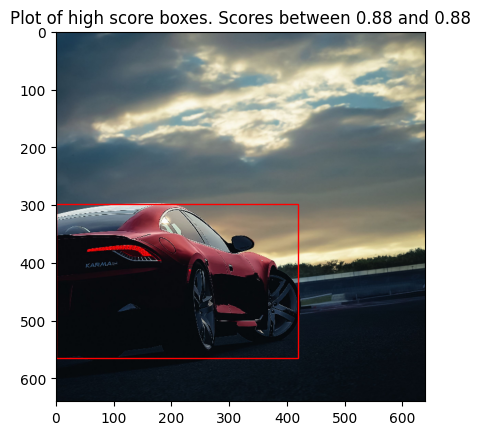

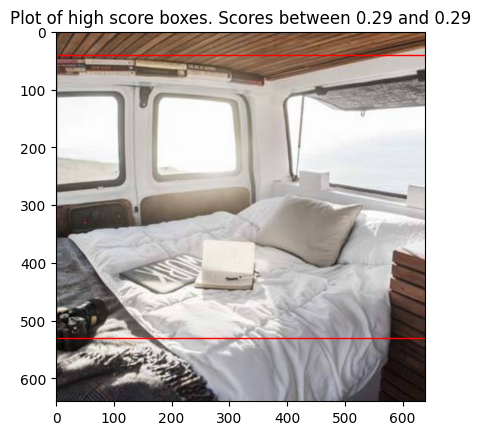

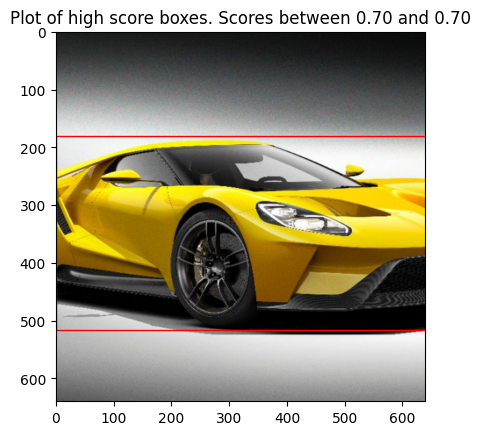

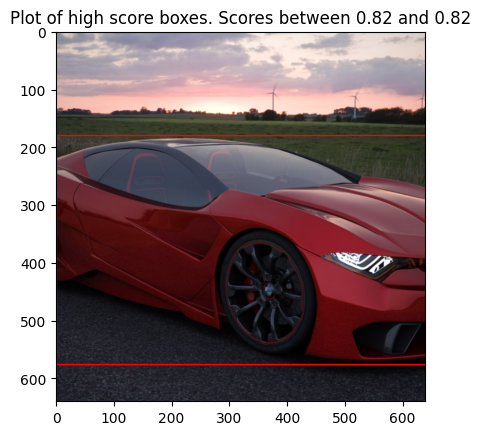

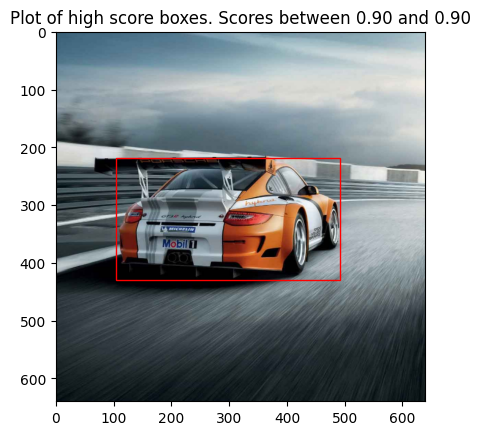

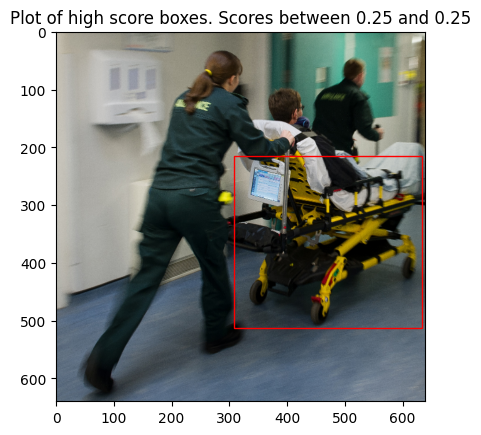

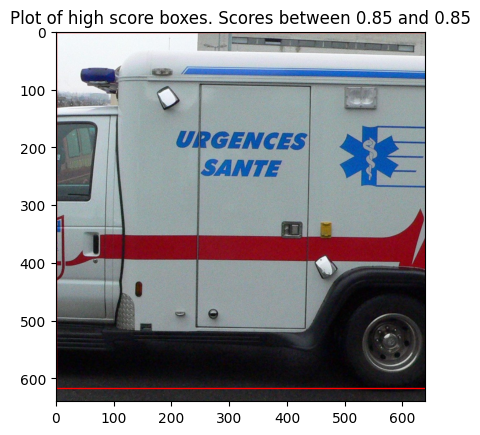

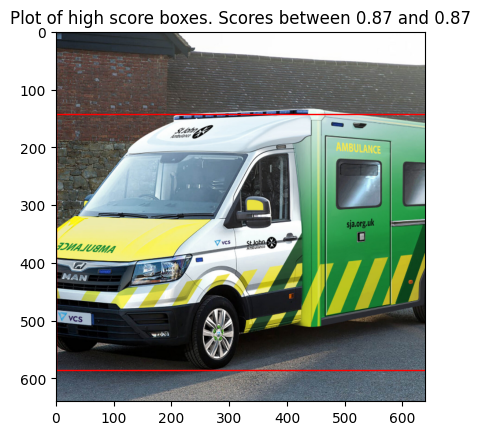

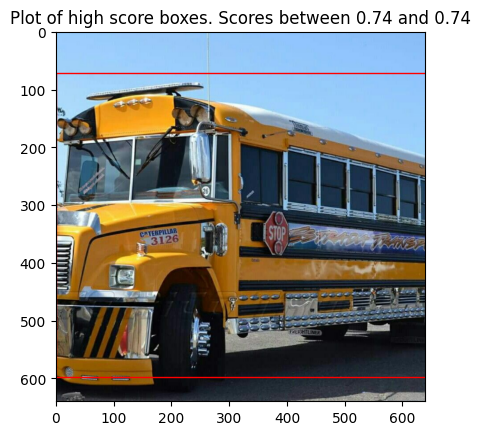

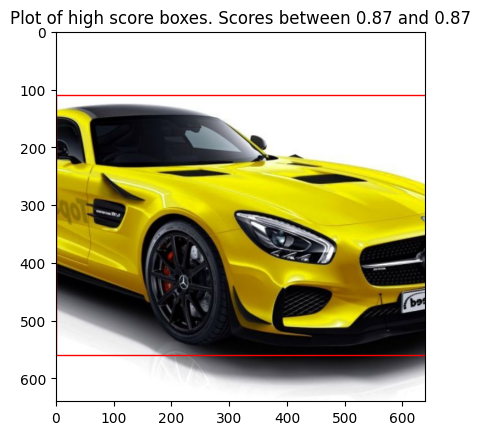

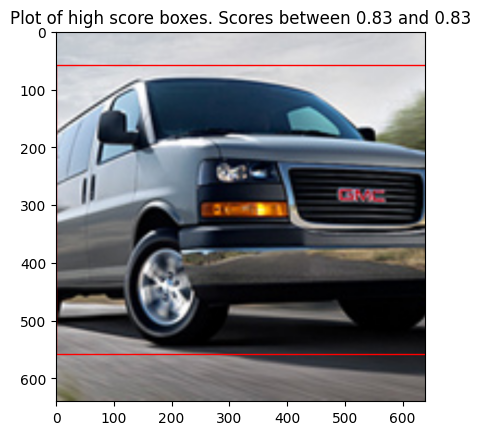

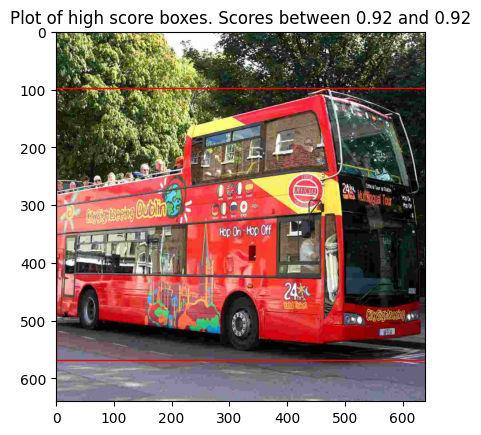

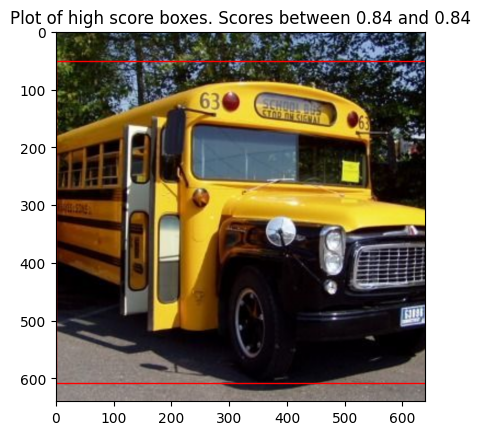

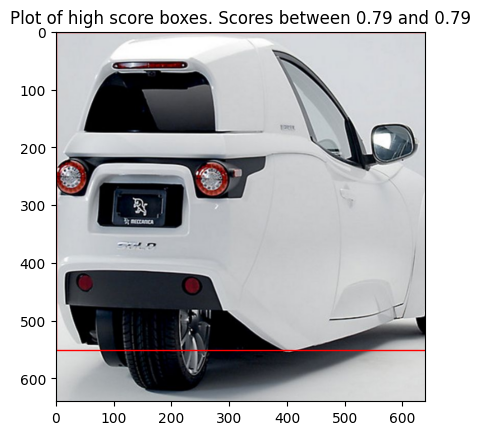

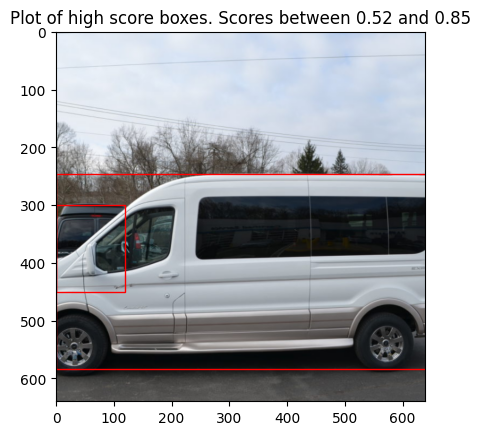

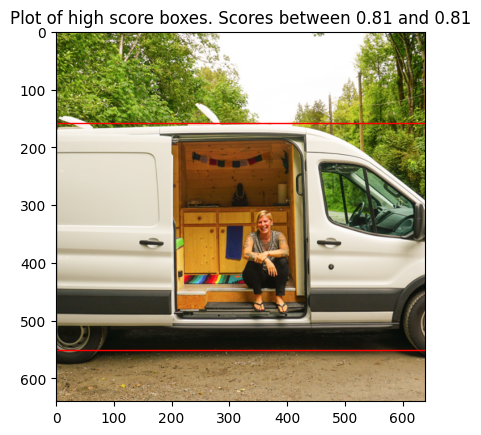

In [12]:
model_name = "yolov5m_vehicles"
onnx_path = f"./models/yolov5m_vehicles/{model_name}.onnx"
assert os.path.isfile(onnx_path), "Please provide valid path for ONNX file"

# Initialize a new client runner
runner = ClientRunner(hw_arch="hailo8l")
# Any other hw_arch can be used as well.

# Translate YOLO model from ONNX
runner.translate_onnx_model(onnx_path)
# Note: NMS will be detected automatically, with a message that contains:
#   - 'original layer name': {'w': [WIDTHS], 'h': [HEIGHTS], 'stride': STRIDE, 'encoded_layer': TRANSLATED_LAYER_NAME}
# Use nms_postprocess(meta_arch=yolov5) to add the NMS.

# Add model script with NMS layer at the network's output.
model_script_commands = [
    "normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n",
    "resize_input1= resize(resize_shapes=[640,640])\n",
    "nms_postprocess(meta_arch=yolov5, engine=cpu, nms_scores_th=0.2, nms_iou_th=0.4)\n",
]
# Note: Scores threshold of 0.0 means no filtering, 1.0 means maximal filtering. IoU thresholds are opposite: 1.0 means filtering boxes only if they are equal, and 0.0 means filtering with minimal overlap.
runner.load_model_script("".join(model_script_commands))

# Apply model script changes
runner.optimize_full_precision()

# Infer an image with the Hailo Emulator
with runner.infer_context(InferenceContext.SDK_FP_OPTIMIZED) as ctx:
    nms_output = runner.infer(ctx, calib_dataset[:16, ...])
HEIGHT = 640
WIDTH = 640
# For each image
for i in range(16):
    found_any = False
    min_score = None
    max_score = None
    # Go over all classes
    for class_index in range(nms_output.shape[1]):
        score, box = nms_output[i][class_index, 4, :], nms_output[i][class_index, 0:4, :]
        # Go over all detections
        for detection_idx in range(box.shape[1]):
            cur_score = score[detection_idx]
            # Discard null detections (because the output tensor is always padded to MAX_DETECTIONS on the emulator interface.
            # Note: On HailoRT APIs (that are used on the Inference Tutorial, and with C++ APIs), the default is a list per class. For more information look for NMS on the HailoRT user guide.
            if cur_score == 0:
                continue

            # Plotting code
            if not found_any:
                found_any = True
                fig, ax = plt.subplots()
                ax.imshow(Image.fromarray(np.array(calib_dataset[i], np.uint8)))
            if min_score is None or cur_score < min_score:
                min_score = cur_score
            if max_score is None or cur_score > max_score:
                max_score = cur_score
            (
                y_min,
                x_min,
            ) = box[0, detection_idx] * HEIGHT, box[1, detection_idx] * WIDTH
            y_max, x_max = box[2, detection_idx] * HEIGHT, box[3, detection_idx] * WIDTH
            center, width, height = (x_min, y_min), x_max - x_min, y_max - y_min
            # draw the box on the input image
            rect = patches.Rectangle(center, width, height, linewidth=1, edgecolor="r", facecolor="none")
            ax.add_patch(rect)

    if found_any:
        plt.title(f"Plot of high score boxes. Scores between {min_score:.2f} and {max_score:.2f}")
        plt.show()